### Isolation Forest (iForest)

* Isolation Forest or IForest applies a tree structure to isolate every instance. Anomalies will be the data points first to be singled out, whereas normal points tend to hide deep in the tree <br>
* When we have data, we use "cuts" to understand how many branches the tree should split before reaching to the final one. The more cuts it takes to separate a dot, the deeper it sits in the tree. The inverse of the number of cuts is the anomaly score.
* The number of depths is a good proxy for the anomaly score.
* An iTree is a binary tree, where each node in the tree has exact zero or two daughter nodes. An iTree grows until one of the following conditions is met: i) the end node has only one data point, ii) all data in a node has the same values, iii) the tree reaches the height limit. 

* A small sample size of the iTree produces better results because swaming and masking effects are reduced.


* When we talk about "ensemble" trees, we are trying to overcome the limitation of overfitting. Decision trees tend to be overfit the data, so we can build many trees on top of the data and average the predictions.

* To start the algorithm, there is a number of rows and columns selected randomly (subsets) and iTree is built on top of each table to render the results. 

* The goal of the iForest is to assign an outlier score to each instance (row). An instance can have up to N scores that are then averaged out to get the final score.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data

contamination = 0.05

n_train = 500
n_test = 500
n_features = 6

X_train, X_test, y_train, y_test = generate_data(
                                    n_train=n_train,
                                    n_test=n_test,
                                    n_features=n_features,
                                    contamination=contamination,
                                    random_state=123)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5
0,2.396090,2.092611,2.073392,1.988262,1.953473,2.450997
1,1.631040,1.746182,1.898050,2.380148,1.967332,1.858916
2,1.824683,2.131412,2.028829,1.703454,2.502966,2.119108
3,2.106098,2.165173,2.340826,2.170109,1.749139,1.678661
4,1.829647,1.775596,1.829438,2.054768,1.577190,1.594549


In [5]:
def count_stat(vector):
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

def descriptive_stat_threshold(df, pred_score, threshold):
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score

    df['Group'] = np.where(df['Anomaly_Score'] < threshold,
                           'Normal', 'Outlier')
    
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score': 'Count'})

    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100

    stat = df.groupby('Group').mean().round(2).reset_index()

    stat = cnt.merge(stat, left_on='Group', right_on='Group')

    return (stat)

def confusion_matrix_threshold(actual, score, threshold):
    actual_pred = pd.DataFrame({'actual': actual, 'pred': score})
    actual_pred['pred'] = np.where(actual_pred['pred'] <= threshold, 0, 1)
    cm = pd.crosstab(actual_pred['actual'], actual_pred['pred'])
    return cm

def confusion_matrix(actual, pred):
    actual_pred = pd.DataFrame({'actual': actual, 'pred': pred})
    cm = pd.crosstab(actual_pred['actual'], actual_pred['pred'])
    return cm

def plot_data():
    plt.scatter(X_train_pd[0], X_train_pd[1], alpha=0.8, c=y_train)
    plt.title('Scatter Plot')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()


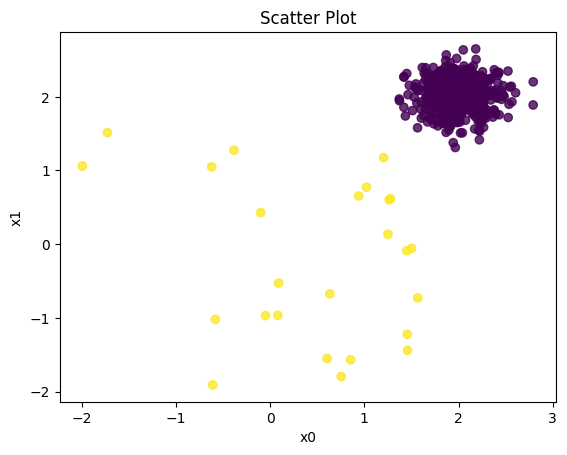

In [6]:
plot_data()

## Step 1: Build the Model 

### Isolation Forest Parameters

1. **max_samples**: 
    * Represents the number of instances (rows) to be drawn from the training data to build a tree.
    * Even though you might expect larger samples to produce better results, a smaller sample size, such as 40 instances, can often be more effective. This is because a small sample can efficiently isolate anomalies without the need for an extensive tree structure.

2. **contamination**:
    * It denotes the proportion of outliers you believe are present in your dataset. 
    * For instance, setting it to 0.05 indicates an estimated 5% of outliers in the dataset.

3. **threshold**: 
    * Refers to the cutoff value used to determine whether a data instance is an anomaly or not.
    * Understanding this threshold helps in setting precise criteria for anomaly detection.

4. **n_estimators**: 
    * Specifies the number of trees in the ensemble.
    * By default, the ensemble consists of 100 trees. However, you can adjust this number based on your dataset and the level of precision you seek.

5. **max_features**: 
    * Denotes the number of features drawn from the training dataset for each base estimator or tree.
    * Adjusting this can help in controlling the randomness of feature selection, thereby affecting the model's variance and bias.**

6. **n_jobs**: 
    * Determines the number of jobs to run in parallel during both the 'fit' and 'predict' operations.
    * Setting it to -1 allows the algorithm to utilize all available CPU cores, optimizing computation speed.

    **Total available features (X) to train each base estimator. When set to a float, it interprets that float as a percentage. So, max_features=1.0 means it uses 100% of the features, which is essentially all of them.


In [9]:
from pyod.models.iforest import IForest

isft = IForest(contamination=0.05, max_samples=40, behaviour='new')
isft.fit(X_train)

# Training data
y_train_scores = isft.decision_function(X_train)
y_train_pred = isft.predict(X_train)

# Test data
y_test_scores = isft.decision_function(X_test)
y_test_pred = isft.predict(X_test)

# Threshold for the defined contamination rate
print(f'The threshold for the defined contamination rate: {isft.threshold_}')

print(f'The training data: {count_stat(y_train_pred)}')
print(f'The testing data: {count_stat(y_test_pred)}')


The threshold for the defined contamination rate: -4.349819116011844e-15
The training data: {0: 475, 1: 25}
The testing data: {0: 473, 1: 27}


In [10]:
isft.get_params()

{'behaviour': 'new',
 'bootstrap': False,
 'contamination': 0.05,
 'max_features': 1.0,
 'max_samples': 40,
 'n_estimators': 100,
 'n_jobs': 1,
 'random_state': None,
 'verbose': 0}

* .feature_importances_: This is an attribute of the trained model. For many tree-based models in scikit-learn (like Decision Trees, Random Forests, Gradient Boosted Trees, and others), the .feature_importances_ attribute provides an array of importance scores for each feature (or column) in your dataset. These scores represent how "important" or "influential" each feature was in making predictions (or, in the case of Isolation Forest, in isolating anomalies). A higher value indicates a more influential feature.

In [11]:
isft_vi = isft.feature_importances_

isft_vi

array([0.20373837, 0.14240939, 0.15697331, 0.17678358, 0.17556283,
       0.14453253])

In [12]:
sum(isft_vi)

1.0

<Axes: >

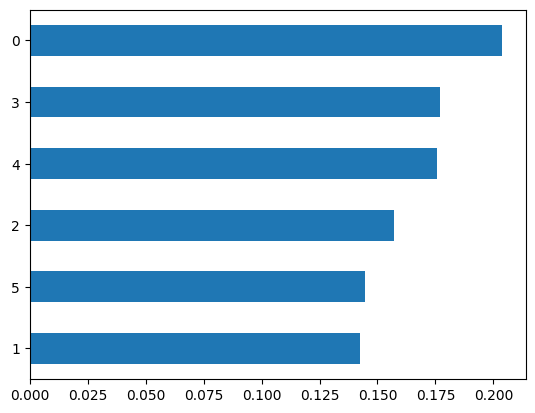

In [16]:
for_plot = pd.DataFrame({'x_axis': X_train_pd.columns, 'y_axis': isft_vi}).sort_values(by='y_axis', ascending=True)

for_plot['y_axis'].plot.barh()

### Determine the Threshold

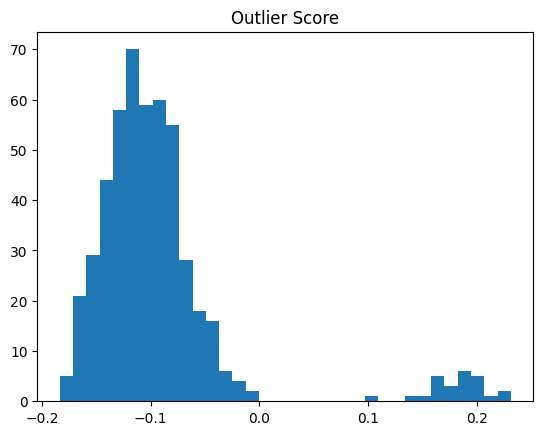

In [17]:
plt.hist(y_train_scores, bins='auto')
plt.title('Outlier Score')
plt.show()

## Step 3: Descriptive Statistics

In [18]:
threshold = isft.threshold_

descriptive_stat_threshold(X_train, y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.11
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,0.18


In [19]:
descriptive_stat_threshold(X_test, y_test_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,473,94.6,2.01,2.01,2.01,1.99,2.01,2.00,-0.10
1,Outlier,27,5.4,0.19,-0.34,-0.07,0.09,0.08,0.29,0.17


In [21]:
confusion_matrix_threshold(y_train, y_train_scores, threshold)

pred,0,1
actual,,
0.0,475,0
1.0,0,25


In [22]:
confusion_matrix_threshold(y_test, y_test_scores, threshold)

pred,0,1
actual,,
0.0,473,2
1.0,0,25


## Step 4: Averages

### Analyzing the Impact of Different Number of Trees in Isolation Forest

The provided code evaluates the performance of the Isolation Forest algorithm across varying numbers of trees (`n_estimators`). Let's break down the key steps:

1. **Importing Necessary Libraries**:
    ```python
    from pyod.models.combination import aom, moa, average, maximization
    from pyod.utils.utility import standardizer
    from pyod.models.iforest import IForest
    ```
    The code starts by importing various utilities and models. The primary focus here is the `IForest`, which represents the Isolation Forest model, and `standardizer` for data normalization.

2. **Data Standardization**:
    ```python
    X_train_norm, X_test_norm = standardizer(X_train, X_test)
    ```
    Given that machine learning models often perform better on standardized data, the training and testing datasets are normalized. This ensures each feature has a mean of zero and a standard deviation of one.

3. **Defining the Range for Number of Trees**:
    ```python
    k_list = [20, 30, 40, 50, 60, 100, 200, 300, 400, 500]
    n_clf = len(k_list)
    ```
    A list of values is established to represent different numbers of trees that the model will be tested against. This list will be iterated over, and for each value, an Isolation Forest will be trained and its performance noted.

4. **Initializing Placeholders for Results**:
    ```python
    train_scores = np.zeros([X_train.shape[0], n_clf])
    test_scores = np.zeros([X_test.shape[0], n_clf])
    ```
    Arrays are initialized to store the anomaly scores (decision scores) for each model iteration, both for the training and testing datasets.

5. **Training and Evaluating Models**:
    ```python
    for i in range(n_clf):
        k = k_list[i]
        isft = IForest(contamination=0.05, n_estimators=k)
        isft.fit(X_train_norm)
        train_scores[:, i] = isft.decision_function(X_train_norm)
        test_scores[:, i] = isft.decision_function(X_test_norm)
    ```
    For each specified number of trees in `k_list`, an Isolation Forest model is instantiated and trained. Post-training, the model's decision function is called to obtain the anomaly scores for both the training and test datasets. These scores are stored in their respective arrays.

6. **Final Data Standardization**:
    ```python
    train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)
    ```
    After obtaining decision scores across all the models, it's vital to standardize these scores, especially if one plans to compare or combine them in subsequent steps.

In summary, this code provides a systematic approach to understand the impact of different numbers of trees on the Isolation Forest's performance. By examining a range of values, one can ascertain the optimal number of trees that provides the best balance between detection capability and computational efficiency for a given dataset.


In [26]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.iforest import IForest

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of maximum samples
k_list = [20, 30, 40, 50, 60, 100, 200, 300, 400, 500]
n_clf = len(k_list)

# Prepare DataFrames to store results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]

    isft = IForest(contamination=0.05, n_estimators=k)
    isft.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = isft.decision_function(X_train_norm)
    test_scores[:, i] = isft.decision_function(X_test_norm)

# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

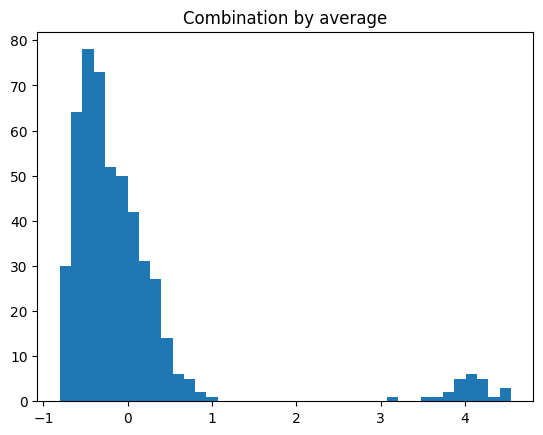

In [29]:
# Combination by average
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)

plt.hist(y_train_by_average, bins='auto')
plt.title('Combination by average')
plt.show()

In [30]:
descriptive_stat_threshold(X_train, y_train_by_average, 1.0)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.21
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,4.05


In [31]:
descriptive_stat_threshold(X_test, y_test_by_average, 1.0)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,472,94.4,2.01,2.01,2.01,1.99,2.01,2.00,-0.19
1,Outlier,28,5.6,0.24,-0.26,0.02,0.17,0.17,0.33,3.81
